# Train ranking model with user representation
 - In the following notebook we will train [DCN model](https://www.tensorflow.org/recommenders/examples/dcn)
 - Model performance will be evaluate via the following metrics:
   - [novelty](https://gab41.lab41.org/recommender-systems-its-not-all-about-the-accuracy-562c7dceeaff):
 $\large\frac{\sum_{u}^{U} \sum_{l}^{L_u} \frac{- log(P_{l})}{|L_u|}}{|U|}$, where $U$ is a set of all users and $L_u$ is a list of recommended arcicles for a user $u$
   - [AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

In [ ]:
!pip install git+https://github.com/seznam/MLPrague-2022.git tensorflow-recommenders==0.5.2 tensorflow-io==0.25.0

  Cloning https://github.com/seznam/MLPrague-2022.git to /tmp/pip-req-build-jaxeyu4o
  Running command git clone -q https://github.com/seznam/MLPrague-2022.git /tmp/pip-req-build-jaxeyu4o
     |████████████████████████████████| 85 kB 2.2 MB/s 
     |████████████████████████████████| 23.4 MB 1.4 MB/s 
     |████████████████████████████████| 462 kB 51.4 MB/s 
  Created wheel for mlprague22: filename=mlprague22-0.0.0-py3-none-any.whl size=5412 sha256=b4f980a37a6f747936feb8b96a11e403872fcb6817844cba30abb3aa42817bd3
  Stored in directory: /tmp/pip-ephem-wheel-cache-lhumea78/wheels/8e/30/46/f600aaa9e010eb66abaae33828e5ee3596fcdccb523d593440
Successfully built mlprague22


In [ ]:
# mount google drive
from mlprague22.util import mount_gdrive
BASE_DIR, IN_COLAB = mount_gdrive("mlprague2022")

Mounted at /content/gdrive


In [ ]:
# import necessary functionality
import gc
import os

from collections import Counter, OrderedDict
from copy import deepcopy

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_recommenders as tfrs

import pandas as pd
import numpy as np

import sklearn.metrics as metrics

from itertools import zip_longest

from mlprague22.evaluation import evaluate, sample_users, sample_items, get_user_prediction
from mlprague22.dataset import prepare_dataset, load_dataset
from mlprague22.util import set_seed

In [ ]:
RANDOM_SEED = 42
BATCH_SIZE = 8_192
EPOCHS = 10

OUTPUT_DIR = os.path.join(BASE_DIR, "data/mind_cold_start_datasets_basic/")
# input data
COLD_START_BEHAVIORS_TRAIN = os.path.join(OUTPUT_DIR, "behaviors_train.tsv")
COLD_START_BEHAVIORS_TEST = os.path.join(OUTPUT_DIR, "behaviors_test.tsv")
NEWS_CATALOGUE_TRAIN = os.path.join(OUTPUT_DIR, "news_catalogue_train.tsv")
NEWS_CATALOGUE_TEST = os.path.join(OUTPUT_DIR, "news_catalogue_test.tsv")
AUXILIARY_DATA_CATALOGUE_TRAIN = os.path.join(OUTPUT_DIR, "auxiliary_data_catalogue_train.tsv")
AUXILIARY_DATA_CATALOGUE_TEST = os.path.join(OUTPUT_DIR, "auxiliary_data_catalogue_test.tsv")
ALL_CATEGORIES_PATH = os.path.join(OUTPUT_DIR, "categories.tsv")
ALL_SUBCATEGORIES_PATH = os.path.join(OUTPUT_DIR, "subcategories.tsv")
# train, test, sampled users
TRAIN_DF_OUTPUT_PATH = os.path.join(OUTPUT_DIR, "train_ex_df.feather")
TEST_DF_OUTPUT_PATH = os.path.join(OUTPUT_DIR, "test_no_item_coldstart_ex_df.feather")
SAMPLED_USERS_DF_OUTPUT_PATH = os.path.join(OUTPUT_DIR, "sampled_users_df.feather")
# user embedding
EMBEDDINGS_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "embeddings")
FT_HISTORY_EMBEDDINGS_TRAIN = "ft_histories_train.vec"
FT_HISTORY_EMBEDDINGS_TEST = "ft_histories_test.vec"
EMBEDDINGS_OUTPUT_TRAIN = os.path.join(EMBEDDINGS_OUTPUT_DIR, FT_HISTORY_EMBEDDINGS_TRAIN)
EMBEDDINGS_OUTPUT_TEST = os.path.join(EMBEDDINGS_OUTPUT_DIR, FT_HISTORY_EMBEDDINGS_TEST)

MODEL_DIR = os.path.join(BASE_DIR, "models")

In [ ]:
# load training/evaluation data
CATEGORIES = (
    pd.read_csv(ALL_CATEGORIES_PATH, sep="\t").sort_values("order").category.tolist()
)
# note: subcategories will be used in TASK 1
SUBCATEGORIES = (
    pd.read_csv(ALL_SUBCATEGORIES_PATH, sep="\t").sort_values("order").subcategory.tolist()
)
behaviors_train = pd.read_csv(COLD_START_BEHAVIORS_TRAIN, sep="\t")
behaviors_test = pd.read_csv(COLD_START_BEHAVIORS_TEST, sep="\t")
news_train = pd.read_csv(NEWS_CATALOGUE_TRAIN, sep="\t")
ft_histories_user_vectors_train = np.loadtxt(EMBEDDINGS_OUTPUT_TRAIN, delimiter=",")
ft_histories_user_vectors_test = np.loadtxt(EMBEDDINGS_OUTPUT_TEST, delimiter=",")

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
# in order to make this notebook at least partially reproducible set seed of the most common randomness sources
set_seed()

### Load training/eval data
 - Recommender system usualy presents users with slate level recommendation:

 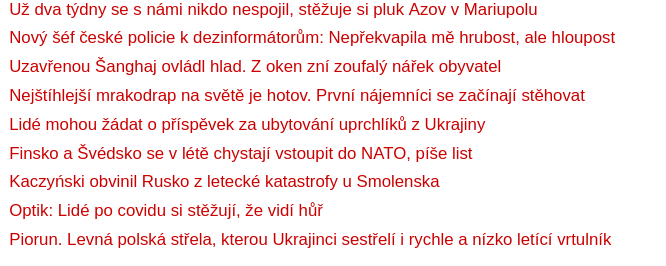


 - But ranking models are trained on single item recommendation and user direct feeedback - all instances on which user clicked are positive instances and those without click are negative
 - Therefore one needs to transform dataset into a format in which each row will match single item recommendation and user feedback
 - We will prepare training and testing dataset and save them in [feather format](https://arrow.apache.org/docs/python/feather.html), which can be easily loaded into tensorflow via [ArrowFeatherDataset](https://www.tensorflow.org/io/api_docs/python/tfio/arrow/ArrowFeatherDataset)

In [ ]:
prepare_dataset(COLD_START_BEHAVIORS_TRAIN, TRAIN_DF_OUTPUT_PATH, ft_histories_user_vectors_train)
train_df = pd.read_feather(TRAIN_DF_OUTPUT_PATH)
display(train_df)

,userid,slateid,history,history_all_categories,history_all_subcategories,user_embedding,impression,click,history_size
0,U13740,1,N45794 N19347 N31801,tv sports tv news sports lifestyle movies news...,tvnews baseball_mlb tvnews newscrime football_...,"[0.027573455, 0.05293599, -0.03803332, -0.0109...",N35729,0,3
1,U91836,2,N31739 N6072 N63045 N43353 N8129 N1569 N17686 ...,news news news finance travel news news news n...,newscrime newsus newscrime markets travelnews ...,"[0.023200372, -0.02856713, 0.009367748, 0.0294...",N39317,0,54
2,U91836,2,N31739 N6072 N63045 N43353 N8129 N1569 N17686 ...,news news news finance travel news news news n...,newscrime newsus newscrime markets travelnews ...,"[0.023200372, -0.02856713, 0.009367748, 0.0294...",N20495,0,54
3,U91836,2,N31739 N6072 N63045 N43353 N8129 N1569 N17686 ...,news news news finance travel news news news n...,newscrime newsus newscrime markets travelnews ...,"[0.023200372, -0.02856713, 0.009367748, 0.0294...",N42977,0,54
4,U73700,3,N7563 N24233,lifestyle lifestyle news sports tv weather spo...,lifestylebuzz lifestylehomeandgarden newsus fo...,"[-0.031641364, 0.02853145, 0.002765765, 0.0484...",N23877,0,2
...,...,...,...,...,...,...,...,...,...
1559405,U44625,156964,N3164 N53854 N44649 N26398 N43983 N16516 N6373...,lifestyle weather news finance entertainment t...,lifestylehomeandgarden weathertopstories newsw...,"[0.010793089, 0.0090169925, -0.031277064, -0.0...",N25561,0,20
1559406,U44625,156964,N3164 N53854 N44649 N26398 N43983 N16516 N6373...,lifestyle weather news finance entertainment t...,lifestylehomeandgarden weathertopstories newsw...,"[0.010793089, 0.0090169925, -0.031277064, -0.0...",N31556,0,20
1559407,U44625,156964,N3164 N53854 N44649 N26398 N43983 N16516 N6373...,lifestyle weather news finance entertainment t...,lifestylehomeandgarden weathertopstories newsw...,"[0.010793089, 0.0090169925, -0.031277064, -0.0...",N23508,0,20
1559408,U44625,156964,N3164 N53854 N44649 N26398 N43983 N16516 N6373...,lifestyle weather news finance entertainment t...,lifestylehomeandgarden weathertopstories newsw...,"[0.010793089, 0.0090169925, -0.031277064, -0.0...",N39317,0,20


In [ ]:
prepare_dataset(COLD_START_BEHAVIORS_TEST, TEST_DF_OUTPUT_PATH, ft_histories_user_vectors_test)
test_df = pd.read_feather(TEST_DF_OUTPUT_PATH)
display(test_df)

,userid,slateid,history,history_all_categories,history_all_subcategories,user_embedding,impression,click,history_size
0,U80234,1,N46039 N53234 N6616 N63573 N38895,tv news tv news finance autos tv movies entert...,tvnews newsus tv-celebrity newsus finance-comp...,"[0.05083861, 0.03707544, -0.041947313, -0.0212...",N50775,0,5
1,U60458,2,N58715 N33438 N54827 N34775,news travel finance news news finance music ne...,newsus travelnews finance-companies newsscienc...,"[0.0401956, -0.03583584, 0.005063751, 0.022478...",N36779,0,4
2,U44190,3,N1150 N16233 N53033,sports news tv news lifestyle sports news ente...,football_nfl newscrime tvnews newsus shop-book...,"[0.016869867, 0.07208146, -0.07160036, 0.02438...",N36779,0,3
3,U44190,3,N1150 N16233 N53033,sports news tv news lifestyle sports news ente...,football_nfl newscrime tvnews newsus shop-book...,"[0.016869867, 0.07208146, -0.07160036, 0.02438...",N50775,0,3
4,U87380,4,N49153 N58518 N7649 N45794 N53033 N29361 N28247,travel news sports sports travel news tv news ...,traveltripideas newsus baseball_mlb football_n...,"[-0.027459757, 0.055927057, 0.005100265, 0.012...",N45057,0,7
...,...,...,...,...,...,...,...,...,...
402722,U16799,73150,,tv tv tv music finance movies,tvnews tv-celebrity tv-celebrity musicnews per...,"[0.035440344, -0.00019471049, -0.108536206, -0...",N33397,0,0
402723,U16799,73150,,tv tv tv music finance movies,tvnews tv-celebrity tv-celebrity musicnews per...,"[0.035440344, -0.00019471049, -0.108536206, -0...",N26572,0,0
402724,U16799,73150,,tv tv tv music finance movies,tvnews tv-celebrity tv-celebrity musicnews per...,"[0.035440344, -0.00019471049, -0.108536206, -0...",N17513,0,0
402725,U8786,73151,,lifestyle lifestyle lifestyle autos health hea...,lifestyleroyals lifestyleroyals lifestyleroyal...,"[0.027152134, 0.081278704, -0.13794707, 0.0008...",N36779,0,0


In [ ]:
# create tensorflow training dataset from preparaded data file
# note: "user_embedding" feature will be used in TASK 2
train_data_cached = load_dataset(TRAIN_DF_OUTPUT_PATH, train_df,
                                 ["history", "impression", "history_all_subcategories", "user_embedding"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
test_data_cached = load_dataset(TEST_DF_OUTPUT_PATH, test_df,
                                ["history", "impression", "history_all_subcategories", "user_embedding"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
# compute how many mini-batched are within one epoch
# information is used later during training as training data are read infinitely
def batch_count(df, batch_size=BATCH_SIZE):
    return (len(df) + batch_size - 1) // batch_size

In [ ]:
BATCHES_PER_EPOCH = batch_count(train_df)
BATCHES_PER_TEST = batch_count(test_df)

### Create embeddings for string features
 - DCN transforms all input data into embeddings - in order to do that we need to tranform text inputs into integers which can be then transformed into embedding 
 - We will use `tf.keras.layers.experimental.preprocessing.TextVectorization` in newer version of tf one might need to use `tf.keras.layers.TextVectorization` instead

In [ ]:
NEWS_IDS = news_train.newsid.tolist()

In [ ]:
history_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    output_mode="int", standardize=None, vocabulary=NEWS_IDS
)

### Create weighted train dataset
 - Dataset suffers from class unbalance as there are not many clicks available
 - We will try to mitigate class unbalance via [class_weight](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights) argument of `fit` methods - which reweights the loss 

In [ ]:
labels, labels_counts = train_label_counts = np.unique(train_df["click"], return_counts=True)

In [ ]:
labels

array([0, 1])

In [ ]:
labels_counts

array([1491348,   68062])

In [ ]:
label_weights = {
    l: (1 / l_count) * (labels_counts.sum() / 2.0)
    for l, l_count in zip(labels, labels_counts)
}

In [ ]:
label_weights

{0: 0.522818953054552, 1: 11.455805001322323}

## Prepare evaluation data
 - We will evaluate model performance on single item level and on slate level
 - AUC metric will be used for item level evaluation and all data from test dataset will be considered
 - Novelty metric will be used for slate level evaluation and only sample of users and items will be considered, if we were to consider all items and users inference would take too much time
  - Items are sampled with respect to their subcategory so they are evenly represented
  - Users are sampled with respect to their history size so ther are evenly represented

In [ ]:
sampled_users = sample_users(test_df, RANDOM_SEED)
sampled_users.shape

(365, 10)

In [ ]:
sampled_items = sample_items(news_train, RANDOM_SEED)
len(sampled_items)

1576

In [ ]:
sampled_users_df = (sampled_users[
    [
         "history_all_categories",
         "history_all_subcategories",
         "history",
         "user_embedding"
    ]
].assign(impression=lambda x: [sampled_items.values]*len(x))
 .explode("impression"))

sampled_users_df.reset_index(drop=True).to_feather(SAMPLED_USERS_DF_OUTPUT_PATH)

sampled_users_data = load_dataset(SAMPLED_USERS_DF_OUTPUT_PATH, sampled_users_df,
                                  ["history", "impression", "history_all_subcategories", "user_embedding"], label_col=None,
                                  batch_size=len(sampled_items))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


### Define DCN model

In [ ]:
class DCN(tfrs.Model):
    """Implementation of stacked DCN architecture"""
    def __init__(
        self,
        features,
        cross_layers=1,
        deep_layers=[128, 64],
        entity_emb_size=64,
        cat_emb_size=8,
        subcat_emb_size=16,
        projection_dim=None,
        normalization=None,
        **model_kwargs,
    ):
        super().__init__()

        self.model_kwargs = deepcopy(model_kwargs)

        entity_id_embedder = tf.keras.layers.Embedding(
            history_vectorizer.vocabulary_size(), entity_emb_size
        )

        feature_fn = {
            "impression": tf.keras.Sequential(
                [
                    tf.keras.layers.InputLayer(input_shape=(1,), dtype=tf.string),
                    history_vectorizer,
                    entity_id_embedder,
                    tf.keras.layers.Reshape([entity_emb_size]),
                ]
            ),
            "history": tf.keras.Sequential(
                [
                    tf.keras.layers.InputLayer(input_shape=(1,), dtype=tf.string),
                    history_vectorizer,
                    entity_id_embedder,
                    tf.keras.layers.GlobalAveragePooling1D(),
                ]
            )
        }

        self._features = features
        self._feature_fn = {key: feature_fn[key] for key in features}
        self._cross_layers = [
            tfrs.layers.dcn.Cross(projection_dim=projection_dim)
            for _ in range(cross_layers)
        ]

        normalization_cls = None
        if normalization == "layer":
            normalization_cls = tf.keras.layers.LayerNormalization
        elif normalization == "batch":
            normalization_cls = tf.keras.layers.BatchNormalization
        elif normalization == "no_normalization":
            pass
        elif normalization:
            raise ValueError(f"Unknown normalization: '{normalization}'")

        self._cross_layers_normalizations = (
            [normalization_cls() for _ in range(cross_layers)]
            if normalization_cls
            else []
        )
        self._deep_layers = [
            tf.keras.layers.Dense(layer_size, activation="relu")
            for layer_size in deep_layers
        ]
        self._deep_layers_normalizations = (
            [normalization_cls() for _ in deep_layers] if normalization_cls else []
        )

        self._sigmoid = tf.keras.layers.Dense(1, activation="sigmoid")

        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall"),
                tf.keras.metrics.AUC(name="auc", curve="PR"),
                tf.keras.metrics.TruePositives(name="TP"),
                tf.keras.metrics.TrueNegatives(name="TN"),
                tf.keras.metrics.FalsePositives(name="FP"),
                tf.keras.metrics.FalseNegatives(name="FN"),
            ],
        )

    def call(self, data, training=None):
        embds = [
            self._feature_fn[feature_name](data[feature_name])
            for feature_name in self._features
        ]

        x0 = tf.concat(embds, axis=1)
        x = x0

        for layer, normalization in zip_longest(
            self._cross_layers, self._cross_layers_normalizations
        ):
            self.layer = layer
            x = layer(x0, x)
            if normalization:
                x = normalization(x, training=training)
            # sometimes all shapes are known, sometimes all shapes are None and sometimes some shapes are known and some
            # are None. The last case is not supported in Cross layers, so this is a hot-fix
            x0 = tf.reshape(x0, tf.shape(x))

        for layer, normalization in zip_longest(
            self._deep_layers, self._deep_layers_normalizations
        ):
            x = layer(x)
            if normalization:
                x = normalization(x, training=training)

        x = self._sigmoid(x)

        return x

    def compute_loss(self, data, training=False):
        # Pick data from generator which yield couples of data and label
        d = data[0]
        labels = data[1]
        sample_weight = data[2] if len(data) == 3 else None
        predictions = self(d, training=training)

        return self.task(
            labels=tf.expand_dims(labels, axis=1),
            predictions=predictions,
            sample_weight=sample_weight,
        )

## Training/evaluation of model
 - train DCN model only on user history and evaluate its performance

In [ ]:
def train(model, name, features):
    """Trains `model` using `features` and calls it using `name`."""
    set_seed()

    train_data = (
        train_data_cached
        .unbatch()
        .shuffle(10000, seed=RANDOM_SEED)
        .repeat()
        .batch(BATCH_SIZE)
    )

    ranking_model = model(
        features=features,
        cross_layers=1,
        deep_layers=[512, 256],
        entity_emb_size=64,
        normalization="batch",
    )

    # hack: turn eager execution on as tf is unable to find lenght of certain dimensions in data
    tf.config.run_functions_eagerly(True)
    ranking_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

    # hack: load one item for tf to be able to decode dimensions properly
    ranking_model(list(train_data.take(1))[0][0])
    # hack: in order to speed up training - turn eager exectuion off
    tf.config.run_functions_eagerly(False)

    print("Training")
    train_log = ranking_model.fit(
        train_data,
        workers=-1,
        use_multiprocessing=True,
        steps_per_epoch=BATCHES_PER_EPOCH,
        epochs=3,
        class_weight=label_weights,
    )

    print("\nEvaluation")
    test_predictions_hat = ranking_model.predict(
        test_data_cached,
        use_multiprocessing=True,
        steps=BATCHES_PER_TEST,
        verbose=1
    )
    test_df[f"pred_{name}"] = test_predictions_hat

    print("\nCustom metrics")
    user_predictions = ranking_model.predict(
        sampled_users_data,
        use_multiprocessing=True,
        steps=len(sampled_users),
        verbose=1
    )
    user_predictions = user_predictions.reshape((-1, len(sampled_items)))
    sampled_users[name] = pd.Series(data=[get_user_prediction(p) for p in user_predictions],
                                    index=sampled_users.index)

    ranking_model.save_weights(
        os.path.join(MODEL_DIR, f"{name.replace(' ', '_')}.weights")
    )

In [ ]:
train(DCN, "DCN model baseline", ["history", "impression"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Training
Epoch 1/3
191/191 [==============================] - 46s 201ms/step - precision: 0.6738 - recall: 0.6827 - auc: 0.7181 - TP: 534012.3125 - TN: 523778.2500 - FP: 258565.8438 - FN: 248144.2500 - loss: 0.6059 - regularization_loss: 0.0000e+00 - total_loss: 0.6059
Epoch 2/3
191/191 [==============================] - 35s 185ms/step - precision: 0.6861 - recall: 0.6979 - auc: 0.7365 - TP: 546029.5000 - TN: 532544.6250 - FP: 249787.8125 - FN: 236390.6250 - loss: 0.5874 - regularization_loss: 0.0000e+00 - total_loss: 0.5874
Epoch 3/3
191/191 [==============================] - 35s 185ms/step - precision: 0.6885 - recall: 0.7040 - auc: 0.7396 - TP: 551070.1250 - TN: 532942.8125 - FP: 249372.6094 - FN: 231716.5625 - loss: 0.5841 - regularization_loss: 0.0000e+00 - total_loss: 0.5841

Evaluation
50/50 [==============================] - 4s 67ms/step

Custom metrics
365/365 [==============================] - 11s 30ms/step


## Task 1

Try using user subcategories history in DCN model, did it improve performance?

In [ ]:
# TASK 1
# Create vectorizer (text to int vector) for subcategories features
# - use `tf.keras.layers.experimental.preprocessing.TextVectorization(output_mode, standardize, vocabulary)`
# - set `output_mode` parameter to value: 'int'
# - set `standardize` parameter to value: None
# - set `vocabulary` parameter to value: SUBCATEGORIES
# tip: search for `history_vectorizer`
subcategory_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(output_mode="int", standardize=None, vocabulary=SUBCATEGORIES)

In [ ]:
class DCNCategories(DCN):
    """Implementation of stacked DCN architecture with categories features"""
    def __init__(
        self,
        features,
        cross_layers=1,
        deep_layers=[128, 64],
        entity_emb_size=64,
        cat_emb_size=8,
        subcat_emb_size=16,
        projection_dim=None,
        normalization=None,
        **model_kwargs,
    ):
        super().__init__([f for f in features if f != "history_all_subcategories"],
                         cross_layers,
                         deep_layers,
                         entity_emb_size,
                         cat_emb_size,
                         subcat_emb_size,
                         projection_dim,
                         normalization,
                         **model_kwargs)

        # TASK 1
        # Create an embedding layer for subcategories features
        # - remove `NotImplementedError` upon this task completion
        # - use `tf.keras.layers.Embedding(input_dim, output_dim)`
        # - use `subcategory_vectorizer` in order to obtain input dimension
        # - use `subcat_emb_size` as output dimension
        # tip: search for `entity_id_embedder` in `DCN`
        subcat_id_embedder = tf.keras.layers.Embedding(subcategory_vectorizer.vocabulary_size(), subcat_emb_size)

        # TASK 1
        # Create feature transformation part for subcategories features
        # - remove `NotImplementedError` upon this task completion
        # - use `tf.keras.Sequential(layers)`
        # - use `tf.keras.layers.InputLayer` with `dtype=tf.string` and `input_shape=(1,)`
        # - transform string indices into integers by `subcategory_vectorize`
        # - create embedding layer by using `subcat_id_embedder`
        # - use `tf.keras.layers.GlobalAveragePooling1D` in order to combine
        #   subcategory vectors to a single history vector
        # tip: see `feature_fn["history"]` in `DCN`
        subcategories_fn = tf.keras.Sequential(
            [
             tf.keras.layers.InputLayer(dtype=tf.string, input_shape=(1,)),
             subcategory_vectorizer,
             subcat_id_embedder,
             tf.keras.layers.GlobalAveragePooling1D()
            ]
        )

        self._features = features
        self._feature_fn = {
            **self._feature_fn, "history_all_subcategories": subcategories_fn
        }

In [ ]:
# TASK 1
# Train the model DCN with subcategories feature and refresh the evaluation
# - use `train(DCNCategories, 'DCNCategories', ["history", "impression", "history_all_subcategories"])`

In [ ]:
train(DCNCategories, 'DCNCategories', ["history", "impression", "history_all_subcategories"])

Training
Epoch 1/3
191/191 [==============================] - 74s 352ms/step - precision: 0.6740 - recall: 0.6852 - auc: 0.7195 - TP: 535902.6250 - TN: 523116.4375 - FP: 259227.7500 - FN: 246253.9375 - loss: 0.6048 - regularization_loss: 0.0000e+00 - total_loss: 0.6048
Epoch 2/3
191/191 [==============================] - 68s 356ms/step - precision: 0.6872 - recall: 0.7038 - auc: 0.7403 - TP: 550692.1250 - TN: 531628.5625 - FP: 250703.7500 - FN: 231728.1250 - loss: 0.5834 - regularization_loss: 0.0000e+00 - total_loss: 0.5834
Epoch 3/3
191/191 [==============================] - 67s 352ms/step - precision: 0.6908 - recall: 0.7140 - auc: 0.7447 - TP: 558871.6875 - TN: 532209.8750 - FP: 250105.7031 - FN: 223915.1094 - loss: 0.5784 - regularization_loss: 0.0000e+00 - total_loss: 0.5784

Evaluation
50/50 [==============================] - 6s 112ms/step

Custom metrics
365/365 [==============================] - 14s 37ms/step


## Task 2

Try implementing parallel DCN structure and using user embeddings created in previous notebook, did it improve performance?

In [ ]:
class DCNParallel(DCN):
    """Implementation of parallel DCN architecture with user embeddings"""
    def __init__(
        self,
        features,
        cross_layers=1,
        deep_layers=[128, 64],
        entity_emb_size=64,
        cat_emb_size=8,
        subcat_emb_size=16,
        projection_dim=None,
        normalization=None,
        **model_kwargs,
    ):
        super().__init__([f for f in features if f != "user_embedding"],
                         cross_layers,
                         deep_layers,
                         entity_emb_size,
                         cat_emb_size,
                         subcat_emb_size,
                         projection_dim,
                         normalization,
                         **model_kwargs)

        # TASK 2
        # Pass user embeddings to the model
        # - remove `NotImplementedError` upon this task completion
        # - use `tf.identity` as layer function
        user_embedding_fn = tf.identity

        self._features = features
        self._feature_fn = {
            **self._feature_fn, "user_embedding": user_embedding_fn
        }

    def call(self, data, training=None):

        embds = [
            self._feature_fn[feature_name](data[feature_name])
            for feature_name in self._features
        ]

        x0 = tf.concat(embds, axis=1)
        x_crs = x0

        for layer, normalization in zip_longest(
            self._cross_layers, self._cross_layers_normalizations
        ):
            self.layer = layer
            x_crs = layer(x0, x_crs)
            if normalization:
                x_crs = normalization(x_crs, training=training)
            # sometimes all shapes are known, sometimes all shapes are None and sometimes some shapes are known and some
            # are None. The last case is not supported in Cross layers, so this is a hot-fix
            x0 = tf.reshape(x0, tf.shape(x_crs))

        # TASK 2
        # Implement parallel deep neural network
        # - remove `NotImplementedError` upon this task completion
        # - apply layers iteratively to `x_dnn`
        # - apply normalization to `x_dnn`
        # tip: see `call` method in `DCN`
        x_dnn = x0

        for layer, normalization in zip_longest(
            self._deep_layers, self._deep_layers_normalizations
        ):
            x_dnn = layer(x_dnn)
            if normalization:
              x_dnn = normalization(x_dnn)

        # TASK 2
        # Merge top layers of cross and deep networks
        # - remove `NotImplementedError` upon this task completion
        # - use `tf.concat([x_crs, x_dnn], axis=1)`
        x_merged = tf.concat([x_crs, x_dnn], axis=1)

        x = self._sigmoid(x_merged)

        return x

In [ ]:
# TASK 2
# Train the parallel DCN model with user embeddings and refresh the evaluation
# - use `train(DCNParallel, 'DCNParallel', ["history", "impression", "user_embedding"])`

In [ ]:
train(DCNParallel, 'DCNParallel', ["history", "impression", "user_embedding"])

Training
Epoch 1/3
191/191 [==============================] - 43s 189ms/step - precision: 0.6791 - recall: 0.6809 - auc: 0.7312 - TP: 532546.0000 - TN: 530742.1250 - FP: 251601.9219 - FN: 249610.4844 - loss: 0.5991 - regularization_loss: 0.0000e+00 - total_loss: 0.5991
Epoch 2/3
191/191 [==============================] - 37s 191ms/step - precision: 0.7055 - recall: 0.7132 - auc: 0.7708 - TP: 558058.1875 - TN: 549344.7500 - FP: 232987.5156 - FN: 224361.9062 - loss: 0.5610 - regularization_loss: 0.0000e+00 - total_loss: 0.5610
Epoch 3/3
191/191 [==============================] - 37s 191ms/step - precision: 0.7154 - recall: 0.7276 - auc: 0.7824 - TP: 569525.1250 - TN: 555697.5000 - FP: 226617.9531 - FN: 213261.2656 - loss: 0.5473 - regularization_loss: 0.0000e+00 - total_loss: 0.5473

Evaluation


## Evaluation

,metric,value
0,novelty DCN model baseline,1.484618
1,novelty DCNCategories,1.738675
2,novelty DCNParallel,1.534901
3,AUC DCN model baseline,0.678884
4,AUC DCNCategories,0.696351
5,AUC DCNParallel,0.702281


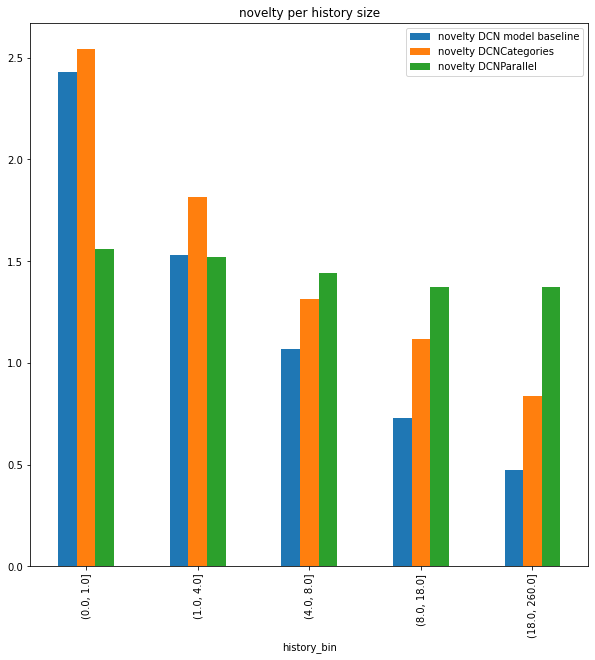

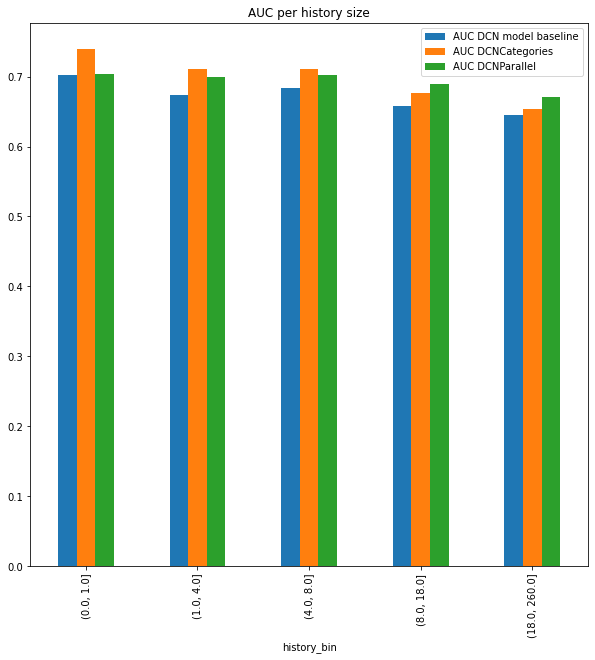

In [ ]:
models = OrderedDict((c, c[5:]) for c in test_df.columns if c.startswith("pred_"))

evaluate(
    sampled_users,
    test_df.rename(columns=models),
    models.values(),
    "click",
    display
)